In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Learning in Repeated Advertising Auctions

### Important Quantities
Given and ad $a$ and a slot $s$, each time $t$ a user arrives:
- $\lambda_s$: probability that the slot $s$ is observed by the user.
- $q_a$: ad's *click-through-rate*, i.e., probability that the ad is clicked by user
- $v_a$: ad's profit per click (e.g., expected profit from sale)

### Assumptions of this model:

- All the quantities are **fixed** and don't vary with time.
- Ad's CTR $q_a$ and profit-per-click $v_a$ don't depend on the slot.
- Prominence $\lambda_s$ pdoesn't depend on ad.

In [2]:
class Auction:
    def __init__(self, *args, **kwargs):
        pass

    def get_winners(self, bids):
        pass

    def get_payments_per_click(self, winners, values, bids):
        pass

    def round(self, bids):
        winners, values = self.get_winners(bids) # allocation mechanism!
        payments_per_click = self.get_payments_per_click(winners, values, bids)
        return winners, payments_per_click
        # return who are the winners and how much they should pay to the platform


# Non-Truthful Auctions

#### In non-truthful auctions, we additionally assume that the **bids are discretized in a finite set**.

## Publisher's Perspective

### Single Slot

In [3]:
class FirstPriceAuction(Auction):
    def __init__(self, ctrs):
        self.ctrs = ctrs
        self.n_adv = len(self.ctrs)
    
    def get_winners(self, bids):
        adv_values = self.ctrs*bids
        adv_ranking = np.argsort(adv_values)
        winner = adv_ranking[-1]
        return winner, adv_values
    
    def get_payments_per_click(self, winners, values, bids):
        payment = bids[winners] # questa volta pago la mia bid, non quella del secondo classificato (non truthful auctions, o anche first-price auctions)
        # dove bids[winners] sarebbe values[winners]/self.ctrs[winners]
        return payment.round(2)

In [4]:
# advertisers' fixed parameters
n_adv = 4 # four advertisers
ctrs = np.array([0.8, 0.65, 0.50, 0.75])
v = np.array([0.7, 1.1, 1.4, 0.85])

# environmental settings
n_users= 3

auction = FirstPriceAuction(ctrs=ctrs)
for u in range(n_users):
    print(f'# User {u}')
    bids = np.random.choice([0.25, 0.5, 0.75, 1], size=n_adv)
    pub_values = bids*ctrs
    print(f'Bids: {bids}, Publisher Values: {pub_values}')
    winner, payment_per_click = auction.round(bids=bids)
    print(f'Auction Winner: {winner}, Payment-per-click: {payment_per_click}')
    print(f'Payment == Bid : {payment_per_click == bids[winner]}')


# User 0
Bids: [0.5  0.5  0.75 0.25], Publisher Values: [0.4    0.325  0.375  0.1875]
Auction Winner: 0, Payment-per-click: 0.5
Payment == Bid : True
# User 1
Bids: [0.25 0.25 0.75 1.  ], Publisher Values: [0.2    0.1625 0.375  0.75  ]
Auction Winner: 3, Payment-per-click: 1.0
Payment == Bid : True
# User 2
Bids: [0.5  0.25 0.25 1.  ], Publisher Values: [0.4    0.1625 0.125  0.75  ]
Auction Winner: 3, Payment-per-click: 1.0
Payment == Bid : True


## Advertiser's Perspective: learning in repeated first price auctions

#### We assume from now on that all CTRs are equal to 1

#### What is the best **and feasible** sequence of bids I can do? How much cumulative utility does a clairvoyant gain?

#### In adversarial settings the baseline is weaker, and resembles the best-arm in hindsight for adversarial bandits

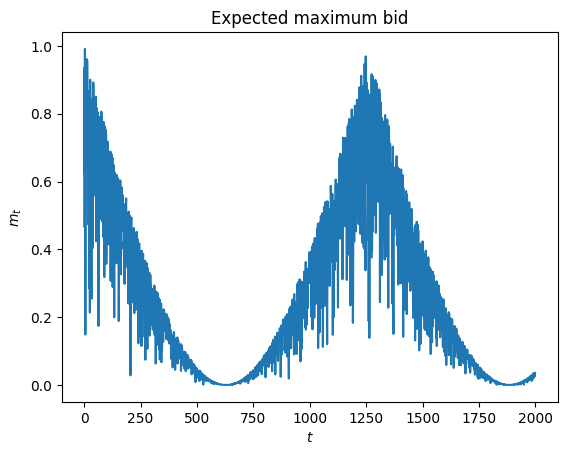

In [5]:
### Adversarial Bidders

# best per ora:
n_users = 2000
B = 120
my_valuation = 0.1

n_advertisers = 3
# n_users = 5000
# B = 250
# my_valuation = 0.1
rho = B/n_users

# non-trivial scenario: competitors sample bids from a uniform with range varying over time
pattern = lambda t: 1-np.abs(np.sin(5*t/n_users))
other_bids = np.array([np.random.uniform(0, pattern(t), size = n_advertisers) for t in range(n_users)]).T
# I assume that competitors may have a larger budget than mine, but they may
# not deplete it.

m_t = other_bids.max(axis=0)

plt.plot(m_t)
plt.title('Expected maximum bid')
plt.xlabel('$t$')
plt.ylabel('$m_t$')
plt.show()

# ho questa funzione che fissa la max bid

Adversarial baseline

In [6]:
available_bids = np.linspace(0,1,11)
win_probabilities = np.array([sum(b > m_t)/n_users for b in available_bids])

In [7]:
def get_clairvoyant_non_truthful(B, my_valuation, m_t, n_users):
    ## I compute my sequence of utilities at every round
    utility = (my_valuation-m_t)*(my_valuation>=m_t)
    ## Now I have to find the sequence of m_t summing up to budget B and having the maximum sum of utility
    ## In second price auctions, I can find the sequence **greedily**:
    sorted_round_utility = np.flip(np.argsort(utility)) # sorted rounds, from most profitable to less profitable
    clairvoyant_utilities = np.zeros(n_users)
    clairvoyant_bids= np.zeros(n_users)
    clairvoyant_payments = np.zeros(n_users)
    c = 0       # Cumulative cost 
    i = 0
    while c <= B-1 and i < n_users:
        clairvoyant_bids[sorted_round_utility[i]] = 1
        clairvoyant_utilities[sorted_round_utility[i]] = utility[sorted_round_utility[i]]
        clairvoyant_payments[sorted_round_utility[i]] = m_t[sorted_round_utility[i]]
        c += m_t[sorted_round_utility[i]]
        i+=1
    clairvoyant_bids = clairvoyant_bids*m_t
    return clairvoyant_bids, clairvoyant_utilities, clairvoyant_payments

In [8]:
expected_clairvoyant_bids, expected_clairvoyant_utilities, expected_clairvoyant_payments = get_clairvoyant_non_truthful(B, my_valuation, m_t, n_users)

### Generalized Multiplicative Pacing for Non-Truthful Auctions

#### Here, we will assume a **full-feedback** setting. In auctions, full-feedback is equivalent of knowing the maximum bid $m_t$ that won the auction (of course, **after** the auction). Moreover, bids will be **discretized** into a finite set of actions.

#### We will leverage a full-feedback, adversarial learner such as Hedge (see Lab 2).

In [9]:
class HedgeAgent:
    def __init__(self, K, learning_rate):
        self.K = K
        self.learning_rate = learning_rate
        self.weights = np.ones(K)
        self.x_t = np.ones(K)/K
        self.a_t = None
        self.t = 0

    def pull_arm(self):
        self.x_t = self.weights/sum(self.weights)
        self.a_t = np.random.choice(np.arange(self.K), p=self.x_t)
        return self.a_t
    
    def update(self, l_t):
        self.weights *= np.exp(-self.learning_rate*l_t)
        self.t += 1

In [10]:
class FFMultiplicativePacingAgent:
    def __init__(self, bids_set, valuation, budget, T, eta):
        self.bids_set = bids_set
        self.K = len(bids_set)
        self.hedge = HedgeAgent(self.K, np.sqrt(np.log(self.K)/T))
        self.valuation = valuation
        self.budget = budget
        self.eta = eta
        self.T = T
        self.rho = self.budget/self.T
        self.lmbd = 1
        self.t = 0

    def bid(self):
        if self.budget < 1:
            return 0
        return self.bids_set[self.hedge.pull_arm()]
    
    def update(self, f_t, c_t, m_t):
        # update hedge
        f_t_full = np.array([(self.valuation-b)*int(b >= m_t) for b in self.bids_set])
        c_t_full = np.array([b*int(b >= m_t) for b in self.bids_set])
        L = f_t_full - self.lmbd*(c_t_full-self.rho)
        range_L = 2+(1-self.rho)/self.rho
        self.hedge.update((2-L)/range_L) # hedge needs losses in [0,1]
        # update lagrangian multiplier
        self.lmbd = np.clip(self.lmbd-self.eta*(self.rho-c_t), 
                            a_min=0, a_max=1/self.rho)
        # update budget
        self.budget -= c_t

#### Trial:

In [11]:
eta = 1/np.sqrt(n_users) # from theory
agent = FFMultiplicativePacingAgent(bids_set = available_bids, 
                                    valuation=my_valuation,
                                    budget=B,
                                    T=n_users, 
                                    eta=eta)

auction = FirstPriceAuction(np.ones(n_advertisers+1))

utilities = np.array([])
my_bids = np.array([])
my_payments = np.array([])
total_wins = 0

np.random.seed(1)
for u in range(n_users):
    # interaction
    my_bid = agent.bid()
    bids = np.append(my_bid, other_bids[:, u].ravel())
    winners, payments_per_click = auction.round(bids=bids)
    my_win = int(winners==0)
    f_t, c_t = (my_valuation-m_t[u])*my_win, m_t[u]*my_win
    agent.update(f_t, c_t, m_t[u])
    # logging
    utilities = np.append(utilities, f_t)
    my_bids = np.append(my_bids, my_bid)
    my_payments = np.append(my_payments, c_t)
    total_wins+=my_win
print(f'Total # of Wins: {total_wins}')

Total # of Wins: 908


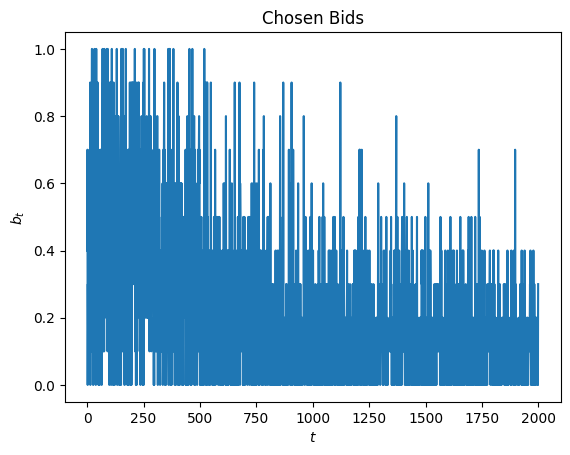

In [12]:
plt.plot(my_bids)
plt.xlabel('$t$')
plt.ylabel('$b_t$')
plt.title('Chosen Bids')
plt.show()

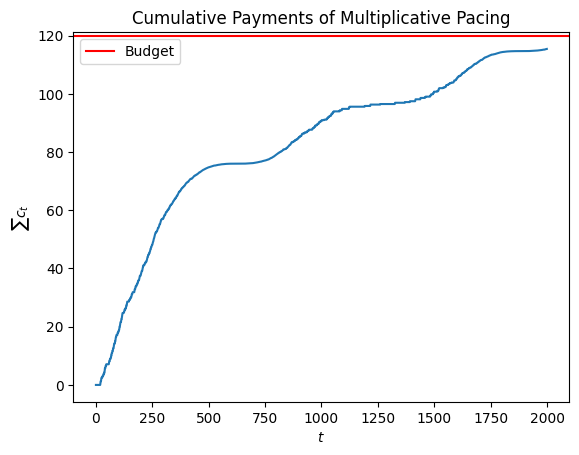

In [13]:
cumulative_payments = np.cumsum(my_payments)
plt.plot(cumulative_payments)
plt.xlabel('$t$')
plt.ylabel('$\sum c_t$')
plt.axhline(B, color='red', label='Budget')
plt.legend()
plt.title('Cumulative Payments of Multiplicative Pacing')
plt.show()

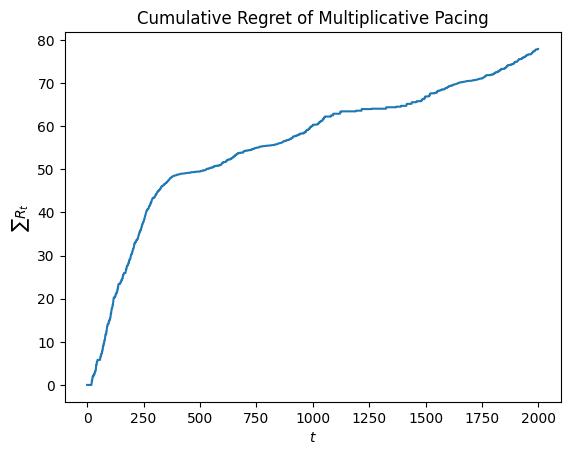

In [14]:
cumulative_regret = np.cumsum(expected_clairvoyant_utilities-utilities)
plt.plot(cumulative_regret)
plt.xlabel('$t$')
plt.ylabel('$\sum R_t$')
plt.title('Cumulative Regret of Multiplicative Pacing')
plt.show()

#### We need multiple rounds for a proper estimation

In [15]:
n_epochs = 50
all_regrets = []
all_payments = []
for i in range(n_epochs):
    agent = FFMultiplicativePacingAgent(bids_set = available_bids, 
                                        valuation=my_valuation,
                                        budget=B,
                                        T=n_users, 
                                        eta=eta)

    auction = FirstPriceAuction(np.ones(n_advertisers+1))
    utilities = np.array([])
    my_bids = np.array([])
    my_payments = np.array([])

    np.random.seed(i)
    for u in range(n_users):
        # interaction
        my_bid = agent.bid()
        bids = np.append(my_bid, other_bids[:, u].ravel())
        winners, payments_per_click = auction.round(bids=bids)
        my_win = int(winners==0)
        f_t, c_t = (my_valuation-m_t[u])*my_win, m_t[u]*my_win
        agent.update(f_t, c_t, m_t[u])
        # logging
        utilities = np.append(utilities, f_t)
        my_payments = np.append(my_payments, c_t)
    all_regrets.append(np.cumsum(expected_clairvoyant_utilities-utilities))
    all_payments.append(np.cumsum(my_payments))

avg_regret = np.array(all_regrets).mean(axis=0)
std_regret = np.array(all_regrets).std(axis=0)

avg_payments = np.array(all_payments).mean(axis=0)
std_payments = np.array(all_payments).std(axis=0)

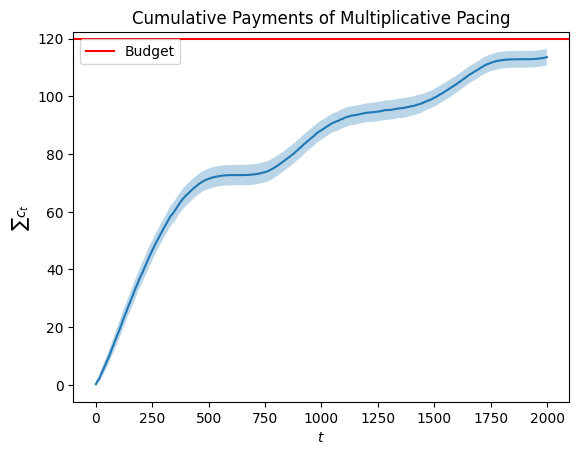

In [16]:
plt.plot(np.arange(n_users), avg_payments)
plt.fill_between(np.arange(n_users), avg_payments-std_payments, avg_payments+std_payments, alpha=0.3)
plt.xlabel('$t$')
plt.ylabel('$\sum c_t$')
plt.axhline(B, color='red', label='Budget')
plt.legend()
plt.title('Cumulative Payments of Multiplicative Pacing')
plt.show()

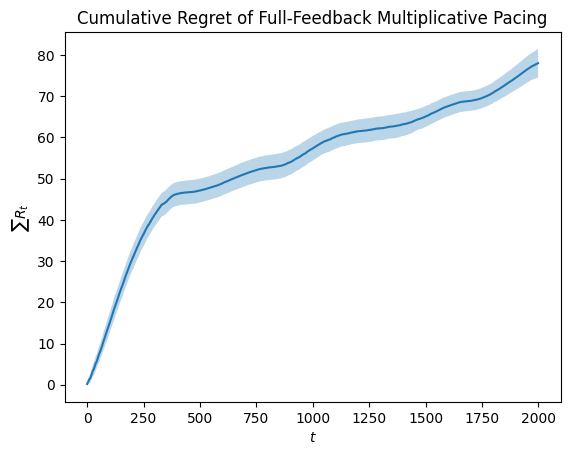

In [17]:
plt.plot(np.arange(n_users), avg_regret)
plt.fill_between(np.arange(n_users), avg_regret-std_regret, avg_regret+std_regret, alpha=0.3)
plt.xlabel('$t$')
plt.ylabel('$\sum R_t$')
plt.title('Cumulative Regret of Full-Feedback Multiplicative Pacing')
plt.show()

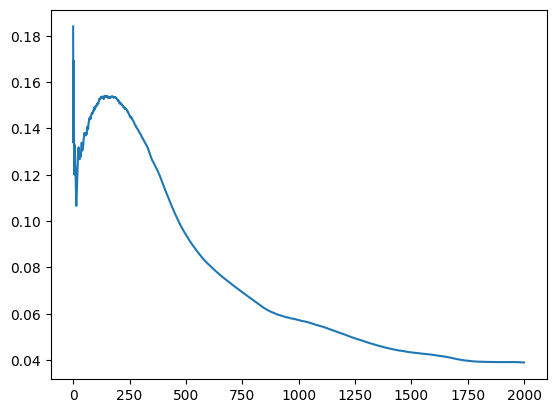

In [18]:
mean_cumulative_regret = avg_regret/np.arange(1,n_users+1)
plt.plot(mean_cumulative_regret)